In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from latticeproteins.conformations import Conformations
from latticeproteins.sequences import RandomSequence

from gpmap.evolve.models import fixation
from gpmap.graph.paths import paths_and_probabilities
from gpmap.graph.paths import flux
from gpmap.graph import draw

import latticegpm
from latticegpm import LatticeGenotypePhenotypeMap
from latticegpm.thermo import LatticeThermodynamics
from latticegpm.search import adaptive_walk

from epistasis.models import EpistasisLinearRegression
from epistasis.plot import coefs, fraction_explained

In [3]:
temperature = 1.0
length = 12

wildtype = "".join(RandomSequence(length))
c = Conformations(length, "database")
dGdependence = "fracfolded"

# Calculate the kth lowest conformations
k = 3
ncontacts = c.MaxContacts()
confs = np.array(c.UniqueConformations(ncontacts))
energies = np.empty(len(confs), dtype=float)
for i, conf in enumerate(confs):
    output = c.FoldSequence(wildtype, 1.0, target_conf=str(conf), loop_in_C=False)
    energies[i] = output[0]
    
sorted_e = np.argsort(energies)
two_states = confs[sorted_e[0:2]]
three_states = confs[sorted_e[0:3]]

In [4]:
mutations = 5

wtlattice = LatticeThermodynamics(wildtype, three_states, temperature=temperature)
mutlattice = adaptive_walk(wtlattice, mutations)
target = mutlattice.native_conf
mutant = mutlattice.sequence

In [5]:
# Construct a genotype-phenotype map
gpm_3state = LatticeGenotypePhenotypeMap.from_mutant(wildtype, mutant, c, temperature=temperature, target_conf=target)
gpm_3state.phenotype_type = dGdependence
gpm_3state.set_partition_confs(three_states)

G_3state = gpm_3state.add_networkx()
G_3state.add_evolutionary_model(fixation)

# stuff
mapping = gpm_3state.map("genotypes", "indices")
s = mapping[wildtype]
t = mapping[mutant]

# Construct a genotype-phenotype map without an ensemble
gpm_2state = LatticeGenotypePhenotypeMap.from_mutant(wildtype, mutant, c, temperature=temperature, target_conf=target)
gpm_2state.phenotype_type = dGdependence
gpm_2state.set_partition_confs(two_states)

G_2state = gpm_2state.add_networkx()
G_2state.add_evolutionary_model(fixation)

/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)


Raise the temperature, to allow trajectories to pass.

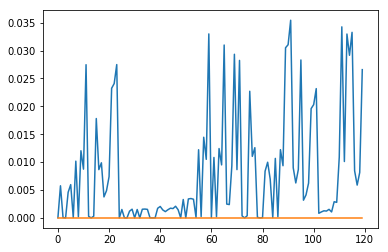

In [6]:
paths_3state, probs_3state = paths_and_probabilities(G_3state, s, t)
paths_2state, probs_2state = paths_and_probabilities(G_2state, s, t)
plt.plot(probs_3state)
plt.plot(probs_2state)

In [8]:
fx

NameError: name 'fx' is not defined

/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)


(<matplotlib.figure.Figure at 0x10ac56cf8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10b22d780>)

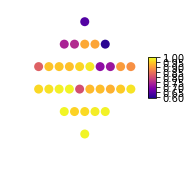

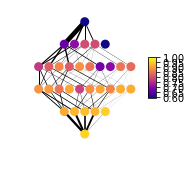

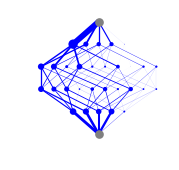

In [9]:
fluxes_3state = flux(G_3state, s, t, transition_model=fixation)
fluxes_2state = flux(G_2state, s, t, transition_model=fixation)

width=8

vmax = max([max(gpm_3state.phenotypes),max(gpm_2state.phenotypes)])
vmin = min([min(gpm_3state.phenotypes),min(gpm_2state.phenotypes)])
#print(round(vmax,2), round(vmin,2))
settings = dict(
    figsize=[2.5,2.5], 
    n_height=9, 
    n_width=9,
    n_linewidths=0,
    n_vmax=round(vmax,2),
    n_vmin=round(vmin,2),
    e_arrows=False, 
    l_alpha=0.0,
    n_colorbar=True
)  

fig, ax, pos = draw.network(G_2state, e_width = width*fluxes_2state, **settings)
#fig.savefig("../img/network-"+dataset+"-2nd-order.pdf", format="pdf")
fig, ax, pos = draw.network(G_3state, e_width = width*fluxes_3state, **settings)
#fig.savefig("../img/network-"+dataset+"-5th-order.pdf", format="pdf")

draw.diff(G_2state, G_3state, s, t)

/Users/Zsailer/.virtualenvs/py3/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


(<matplotlib.figure.Figure at 0x10b2bcfd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10b76ac50>)

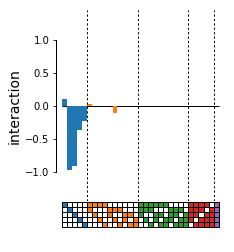

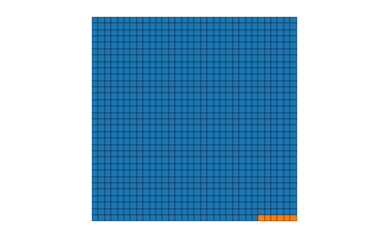

In [10]:
gpm_2state.phenotype_type = "stabilities"
model_2state = EpistasisLinearRegression.from_gpm(gpm_2state, order=0, model_type="global")
model_2state.fit()
fx = [model_2state.score()]
for i in range(1, gpm_2state.binary.length+1):
    model_2state = EpistasisLinearRegression.from_gpm(gpm_2state, order=i, model_type="global")
    model_2state.fit()
    score = model_2state.score() - sum(fx)
    fx.append(score)
coefs(model_2state.epistasis.values, model_2state.epistasis.labels, figsize=(3,4))
fraction_explained(fx[1:])

(<matplotlib.figure.Figure at 0x10c505160>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10b73eef0>)

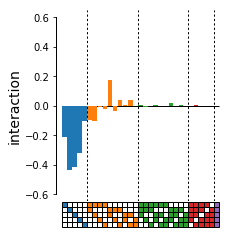

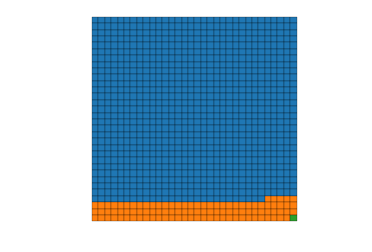

In [11]:
gpm_3state.phenotype_type = "stabilities"
model_3state = EpistasisLinearRegression.from_gpm(gpm_3state, order=0, model_type="global")
model_3state.fit()
fx = [model_3state.score()]
for i in range(1, gpm_3state.binary.length+1):
    model_3state = EpistasisLinearRegression.from_gpm(gpm_3state, order=i, model_type="global")
    model_3state.fit()
    score = model_3state.score() - sum(fx)
    fx.append(score)
coefs(model_3state.epistasis.values, model_3state.epistasis.labels, figsize=(3,4))
fraction_explained(fx[1:])

('DNMWRICDIKTTHDF', 'DNMWRRCDIKMLHAP')
('ALGHLASLERWGDDS', 'CSPKLASLERWGDDD')